# Clustering
## k-means, hierarchical, and more!

#### Jack Bennetto
#### July 25, 2018

## Objectives

#### Today's objectives:

* Explain the difference between **supervised** and **unsupervised** learning
* Implement a **k-means** algorithm for clustering
* Discuss how **curse of dimensionality** affects clustering
* Choose the best k using the **elbow method** or **silhouette scores**
* Implement and interpret **hierarchical clustering**

## Agenda

#### Morning:

 * Supervised/unsupervised learning
 * Clustering
 * k-means algorithm
 * Curse of dimensionality

#### Afternoon:

 * How to choose k
 * Hierarchical clustering
 * Other clustering methods: DBSCAN and distribution-based clustering

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib
from IPython.display import HTML, display

## Supervised learning

So far we've mostly been doing supervise learning, when we try to predict some labels.

 * Linear & logistic regression with lasso or ridge regularization
 * Decision trees, bagging, random forest, boosting	
 * kNN

There are many, many others.

Label $==$ target $==$ endogenous variable $==$ dependent variable $==$ y

## Unsupervised learning

No labels. No target.

Why use it?

 * EDA
 * Discovering latent variables
 * Feature engineering
 * Preprossessing
 * Autoencoding

The most common type of unsupervised learning is clustering, that we're talking about today. In the coming days we'll talk about Principle-Component Analysis (PCA), Singular-Value Decomposition (SVD), and Non-negative Matrix Factorization (NMF).

## Clustering Problem

The goal of clustering is to divide the data into **distinct subgroups** such that observations within each group are similar.

![](images/clusters.png)


## Various Algorithms

There are several approaches to clustering, each with variations.

* k-means clustering
* Hierarchical clustering
* Density-based clustering (DBSCAN)
* Distribution-based clustering
* ...

How do we measure how good the clustering is?

## Within-Cluster Sum of Squares

Measures the goodness of a clustering

$$W(C) = \sum_{k=1}^{K} \frac{1}{K} \sum_{C(i)=k}  \sum_{C(j)=k} || x_i - x_j ||^2 $$

where $K$ is the number of clusters, $C(i)$ is the cluster label of point $i$, and $x_i$ is the position of point $i$.

Do you need to normalize/standardize the data?

# k-means Algorithm

The k-means algorithm involves repeatedly assigning points to clusters and then finding new clusters based on those points.

* Choose a number of clusters k
* 1\. Choose initial clusters
* 2\. Repeatedly:
    * a\. For each of k clusters, compute cluster *centroid* by taking
mean vector of points in the cluster
    * b\. Assign each data point to cluster for which centroid is closest
(Euclidean)

...until clusters stop changing

This approach can be seen as simple version of an **Expectation-Maximization** algorithm. The step of choosing a new centroid is called a *maximization* step, finding the best cluster center given some data. The assignment of data points is the *expectation* step, finding the expected cluster for each point. We'll revisit this in the afternoon.

Discussion: how should we choose initial clusters? Does it matter?

# k-means Algorithm

![The k-means algorithm.](images/kmeans.png)

# k-means++

Consider the points below. How would you break them into two clusters?

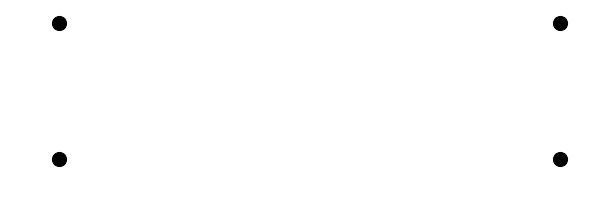

In [2]:
fig, ax = plt.subplots(figsize=(10,3))
colors = 'k'
#ax.scatter([1, 1], [0, 1], marker='x', s=200, c=['r', 'b'])
#colors = ['r', 'b', 'r', 'b']
ax.scatter([0, 0, 2, 2], [0, 1, 0, 1], s=200, c=colors)
ax.axis('off')
plt.show()

There are a couple common way to choose initial clusters. One is to choose randomly cluster centers from the initial points. Another is to randomly assign points to clusters and then find the centers of those.

Like many algorithms, it's easy to get caught in a local minimum. The usual way to avoid this is run the algorithm a number of times and find the best solution. `sklearn` does this automatically with the `n_init` parameter.

That helps, but can we choose better starting points?

k-means++ is the same algorithm as k-means but with a different initialization, attempting to find initial points near the center of different clusters.

 * Choose one point for first center.
 * Repeat:
    
    * Calculate distance from each point to the nearest center $d_i$
    * Choose a point to be the next center, randomly, using a weighed probability $d_i^2$

 ... until k centers have been chosen.

# The Curse of Dimensionality

The Curse of Dimensionality is a way of saying that in high-dimensional space, things behave in unexpected ways. In particular, models based largely on finding the closest distances behave poorly.

Random variation in extra dimensions can hide significant differences between clusters. This can become a serious problem with a large number of dimensions, as no point is really close to any other point and distances alone because less meaningful.

In [5]:
# import function to plot histograms on top of each other cleanly
from src.multihist import multihist

Consider two clusters plotted in increasing numbers of dimensions. How much do they overlap?

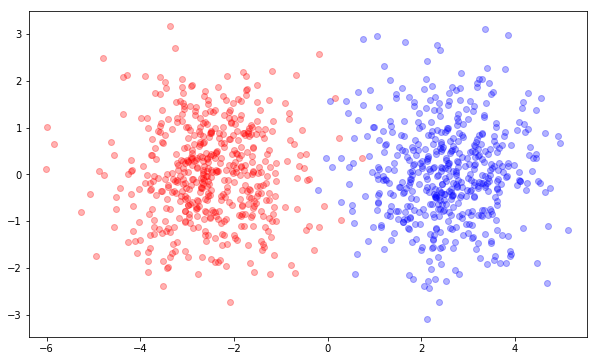

In [6]:
count = 500
sep = 5.

x = np.zeros((2, 2*count))
x[0,:] = np.concatenate((stats.norm(-sep/2., 1).rvs(count),
                        (stats.norm(sep/2., 1).rvs(count))))
x[1, :] = stats.norm(0, 1).rvs(2*count)
fig, ax = plt.subplots(figsize=(10,6))
ax.axis('equal')
ax.scatter(x[0, :count], x[1, :count], c='r', alpha=0.3)
ax.scatter(x[0, count:], x[1, count:], c='b', alpha=0.3)
plt.show()

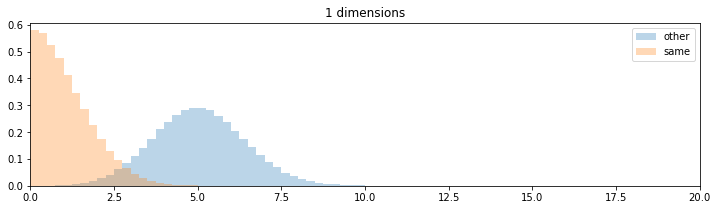

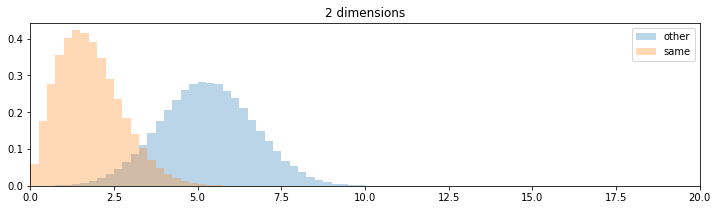

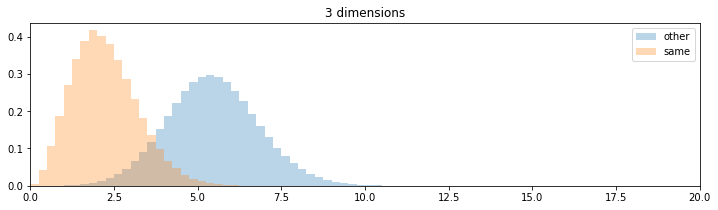

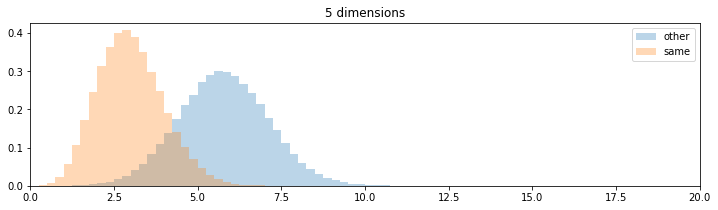

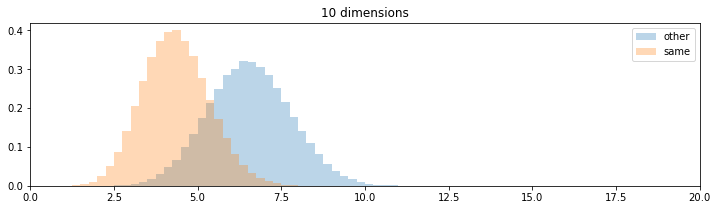

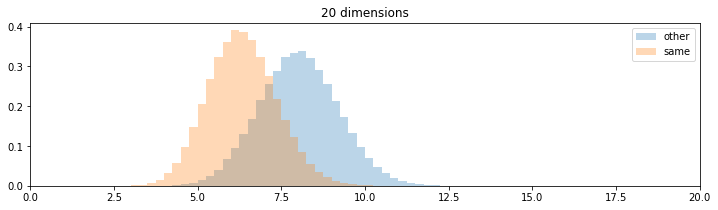

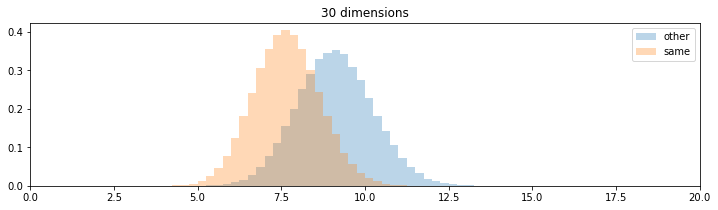

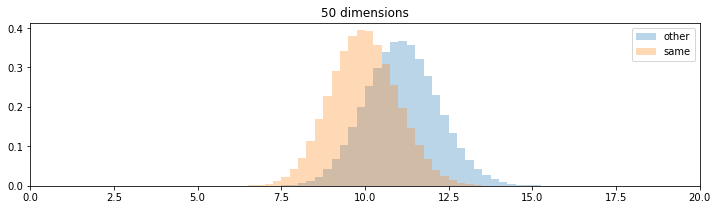

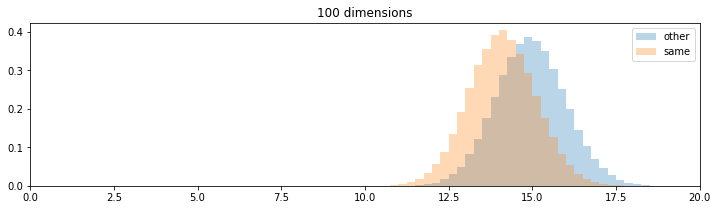

In [7]:
for dims in [1, 2, 3, 5, 10, 20, 30, 50]:
    x = np.zeros((dims, 2*count))
    x[0,:] = np.concatenate((stats.norm(-sep/2., 1).rvs(count),
                            (stats.norm(sep/2., 1).rvs(count))))
    for d in range(1, dims):
        x[d, :] = stats.norm(0, 1).rvs(2*count)

    clusterlabels = ["cluster 1"] * count + ["cluster 2"] * count 
    
    y = []
    dist = []
    for i in range(2*count):
        for j in range(i+1, 2*count):
            d = np.sqrt(sum((x[:,i] - x[:, j])**2))
            dist.append(d)
            y.append("same" if i // count == j // count else "other")
    multihist(np.array(dist), np.array(y), binsize=0.25, figsize=(12,3),
                   xmin=0, xmax=20, title="{0} dimensions".format(dims))
    #plt.axes(frameon=False)

    plt.show()

As the number of dimensions get large, the *every* point is far from its neighbors, even those in the same clusters. The differences between that and neighboring clusters is washed out.

That said, this assumes additional dimensions add nothing. What if each additional dimension adds an equal amount of signal?

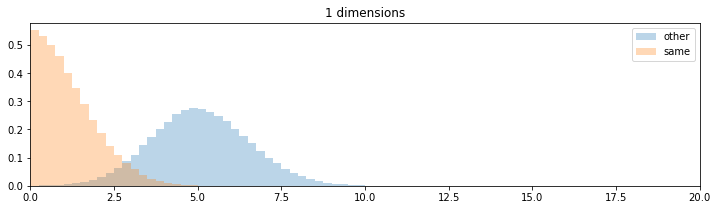

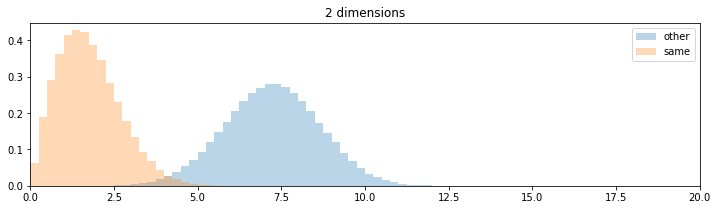

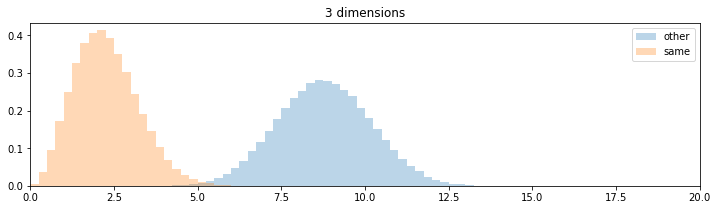

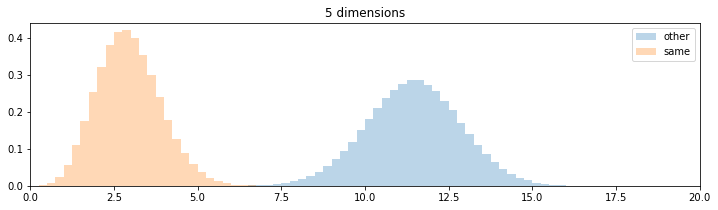

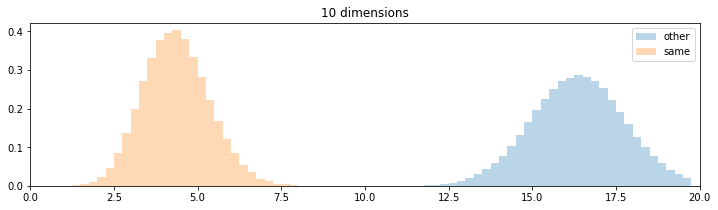

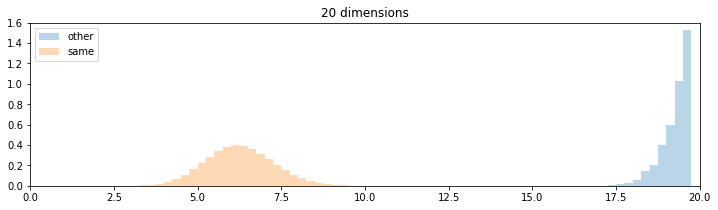

In [8]:
for dims in [1, 2, 3, 5, 10, 20]:
    
    x = np.zeros((dims, 2*count))
    for d in range(0, dims):
        x[d,:] = np.concatenate((stats.norm(-sep/2., 1).rvs(count),
                                (stats.norm(sep/2., 1).rvs(count))))

    clusterlabels = ["cluster 1"] * count + ["cluster 2"] * count 
    
    y = []
    dist = []
    for i in range(2*count):
        for j in range(i+1, 2*count):
            d = np.sqrt(sum((x[:,i] - x[:, j])**2))
            dist.append(d)
            y.append("same" if i // count == j // count else "other")
    multihist(np.array(dist), np.array(y), binsize=0.25, figsize=(12,3),
                   xmin=0, xmax=20, title="{0} dimensions".format(dims))
    #plt.axes(frameon=False)

    plt.show()

So here all the extra dimensions help, but that's not very realistic either. What if we assume that all these that each new dimension has an exponentially decreasing amount of signal.

Here additional dimension helps, but only up to a point. Later dimensions that are almost all noise make things worse.

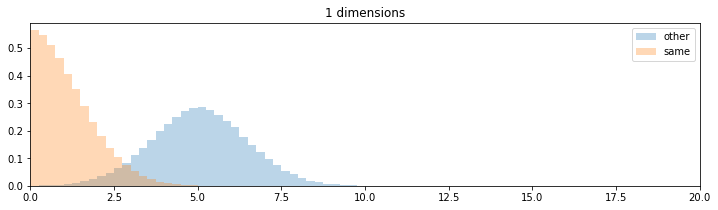

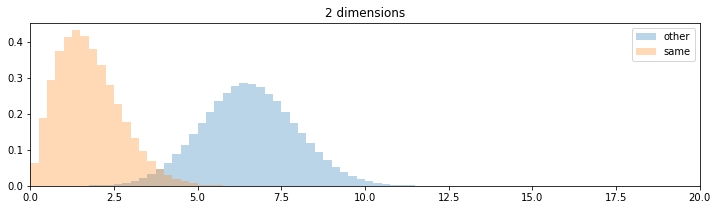

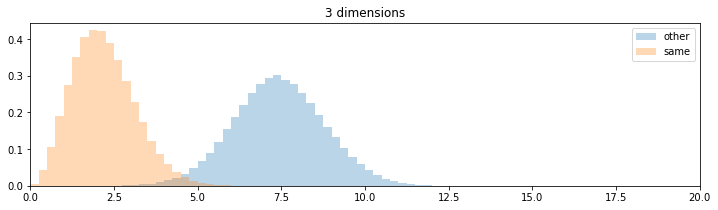

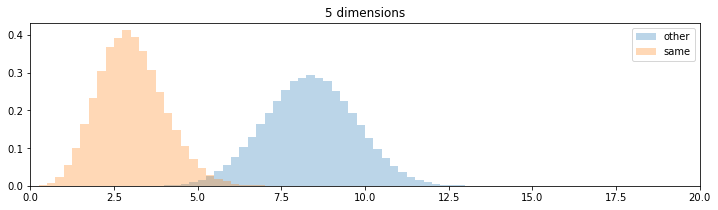

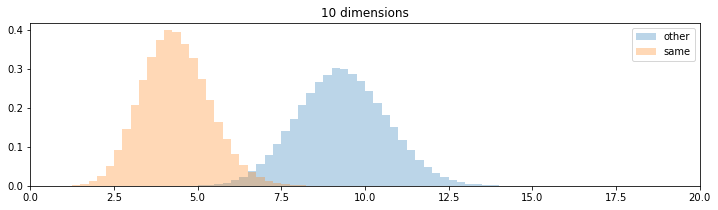

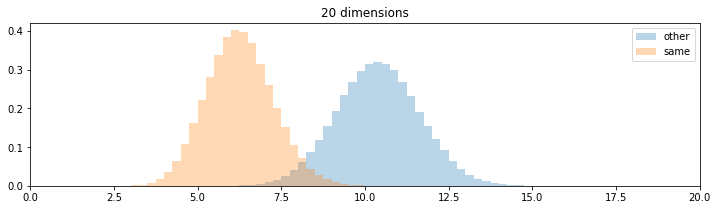

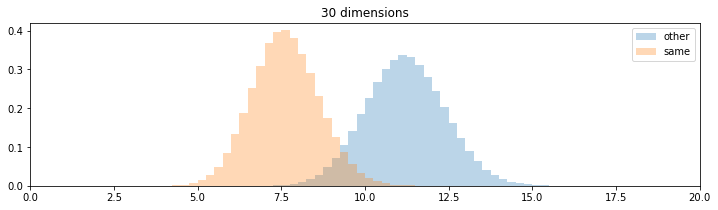

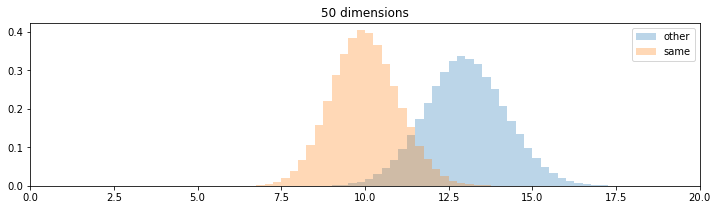

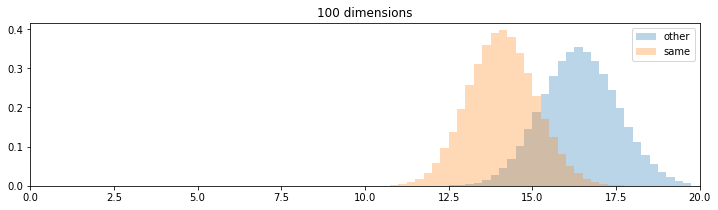

In [10]:
for dims in [1, 2, 3, 5, 10, 20, 30, 50]:
    
    x = np.zeros((dims, 2*count))
    for d in range(0, dims):
        x[d,:] = np.concatenate((stats.norm(-sep/2.*(.8**d), 1).rvs(count),
                                (stats.norm(sep/2.*(.8**d), 1).rvs(count))))
    
    clusterlabels = ["cluster 1"] * count + ["cluster 2"] * count 
    
    y = []
    dist = []
    for i in range(2*count):
        for j in range(i+1, 2*count):
            d = np.sqrt(sum((x[:,i] - x[:, j])**2))
            dist.append(d)
            y.append("same" if i // count == j // count else "other")
    multihist(np.array(dist), np.array(y), binsize=0.25, figsize=(12,3),
                   xmin=0, xmax=20, title="{0} dimensions".format(dims))
    #plt.axes(frameon=False)

    plt.show()

In high dimensions, points become extremely spare -- nothing is very near anything else, to where every point is a similar distance to every other. While you can achieve the same density in with more points, it takes a *lot* more.

# Afternoon Lecture

## What's the correct number of clusters?

This morning we talked about the "best" way to divide data into a given number of clusters, but what number is best?

In [11]:
clusters = [(-2, -3, .75, 100),
            (-5, -5, .75, 75),
            (4, 3, 1.5, 200),
            (1, -3, .5, 150),
            (-1, 0.15, 0.75, 100)]
k = len(clusters)
n = sum([c[3] for c in clusters])

x1 = np.array([])
x2 = np.array([])

for c in clusters:
    x1 = np.concatenate([x1, (stats.norm(c[0], c[2]).rvs(c[3]))])
    x2 = np.concatenate([x2, (stats.norm(c[1], c[2]).rvs(c[3]))])
x = np.stack((x1, x2)).T

(-9, 8)

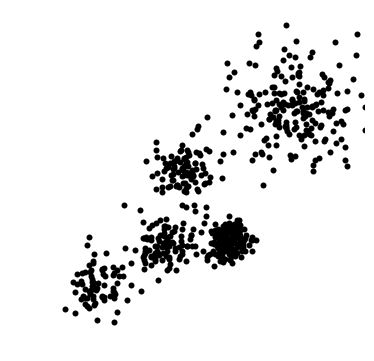

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
ax.axis('equal')
ax.scatter(x[:,0], x[:,1], linewidths=0, color='k')
ax.set_xlim(xmin=-9, xmax=8)


How many clusters do you see?

Let's try fitting them with k-means.

In [13]:
km = KMeans(5)
y = km.fit_predict(x)

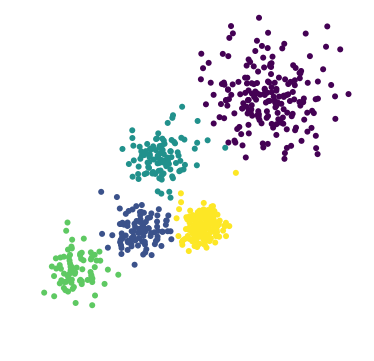

In [14]:
fig, ax = plt.subplots(figsize=(6,6))

ax.axis('off')
ax.axis('equal')
ax.scatter(x[:,0], x[:,1], c=y, linewidths=0)
ax.set_ylim(ymin=-9, ymax=8)
plt.show()

These are basically the clusters we created the data from.

# Choosing K

Can we just use within-cluster sum of squares (WCSS) to choose k?


More clusters $\implies$ lower WCSS.

There are several measures for the "best" k, and no easy answer

 * The Elbow Method
 * Silhouette Score
 * GAP Statistic

First, let's cluster the data above with k-means with various values of $k$.

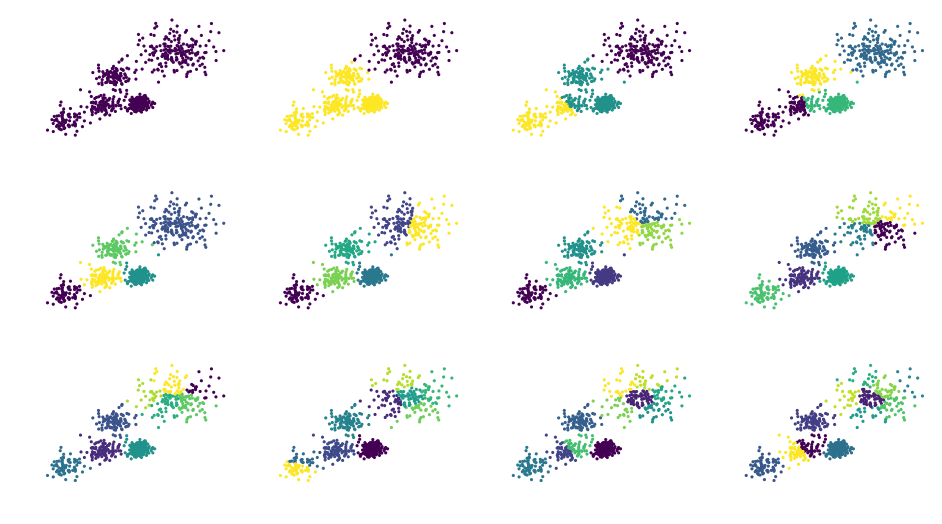

In [15]:
maxk = 13
wcss = np.zeros(maxk)
silhouette = np.zeros(maxk)

fig, axes = plt.subplots(3, 4, figsize=(16,9))

# flatten
axes = [ax for axrow in axes for ax in axrow]

for k, ax in zip(range(1,maxk), axes):
    km = KMeans(k)
    y = km.fit_predict(x)
    ax.axis('off')
    ax.scatter(x[:,0], x[:,1], c=y, linewidths=0, s=10)
    ax.set_ylim(ymin=-9, ymax=8)
    
    
    for c in range(0, k):
        for i1, i2 in itertools.combinations([ i for i in range(len(y)) if y[i] == c ], 2):
            wcss[k] += sum(x[i1] - x[i2])**2
    wcss[k] /= 2
    
    if k > 1:
        silhouette[k] = silhouette_score(x,y)
    

## The Elbow Method

Let's start with the Elbow method. In this, we simply plot the within-cluster sum of squares and try to see what looks like an elbow.

What looks best?

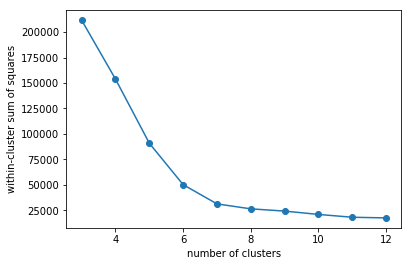

In [16]:
fig, ax = plt.subplots()
ax.plot(range(3,maxk), wcss[3:maxk], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("within-cluster sum of squares")

What we want is some metric we can maximize.

What would that look like?

# Choosing K -- Silhouette Score

For each point $x_i$:

 * $a(i)$ average dissimilarity of $x_i$ with points in the same cluster
 * $b(i)$ average dissimilarity of $x_i$ with points in the nearest cluster
    * "nearest" means cluster with the smallest $b(i)$

$$\text{silhouette}(i) = \frac{b(i) - a(i)}{max(a(i), b(i))} $$

What's the range of silhouette scores?

The silhouette score of a clustering is the average of silhouette score of all points.

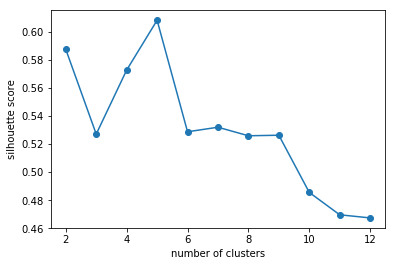

In [17]:
fig, ax = plt.subplots()
ax.plot(range(2,maxk), silhouette[2:maxk], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")
#ax.set_ylim(ymin=0.0, ymax=1.0)

Possible silhouette scores:
 * near 1: very small tight cluster.
 * 0: at the edge of two clusters; could be in either.
 * < 0: oops.

The higher the the average silhouette score, the tighter and more separated the clusters.

# Silhouette Graph

A silhouette graph is a representation of the silhouette score of ever data point, grouped first by cluster and then in decreasing value.

For n_clusters = 2 The average silhouette_score is : 0.587492161461


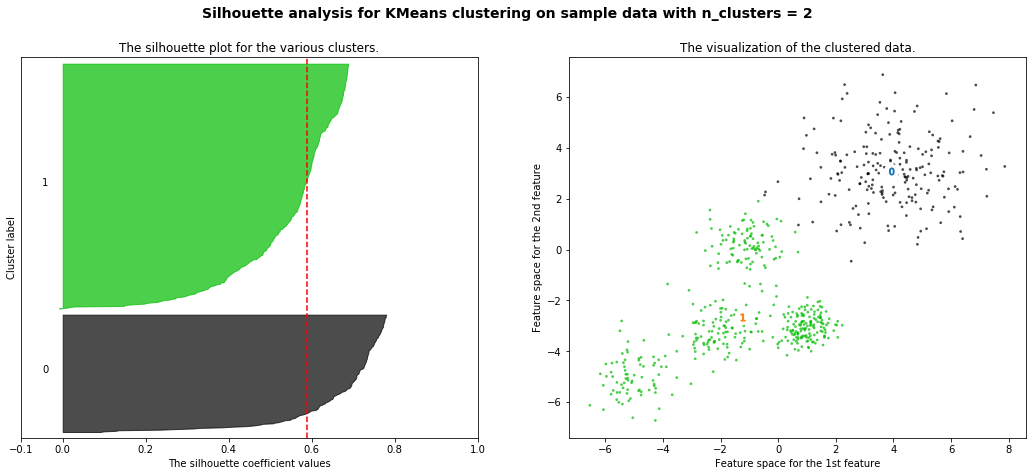

For n_clusters = 3 The average silhouette_score is : 0.527106626801


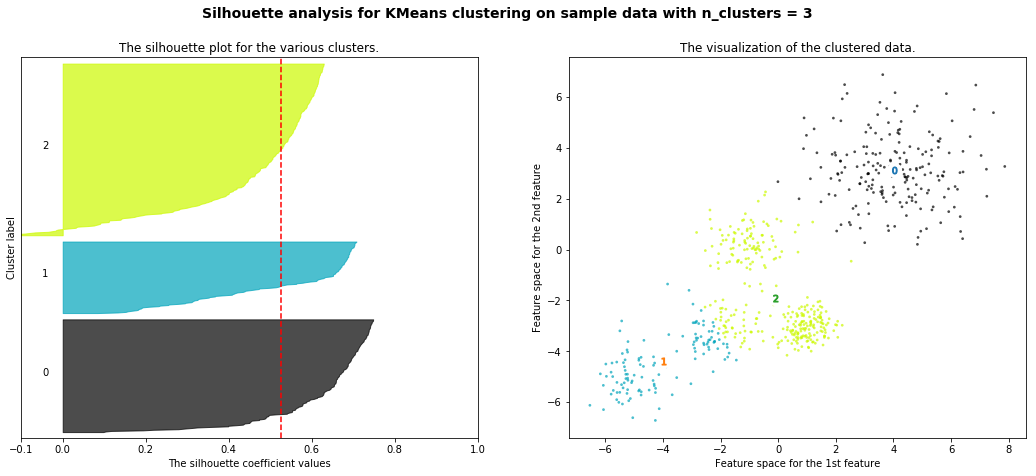

For n_clusters = 4 The average silhouette_score is : 0.572749852462


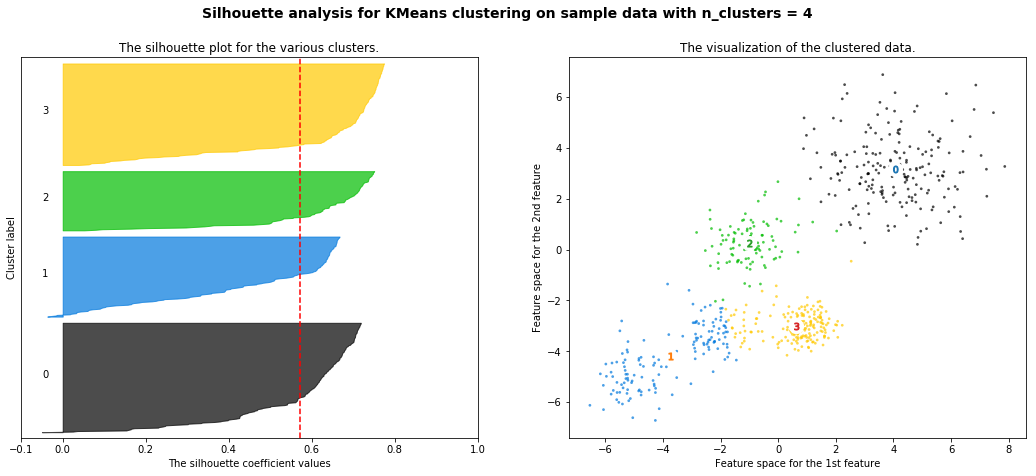

For n_clusters = 5 The average silhouette_score is : 0.608242827221


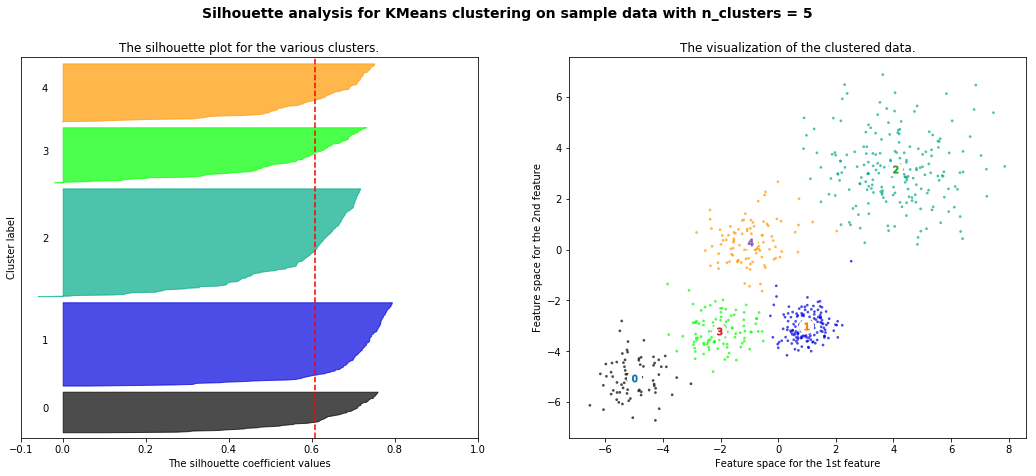

For n_clusters = 6 The average silhouette_score is : 0.528774090334


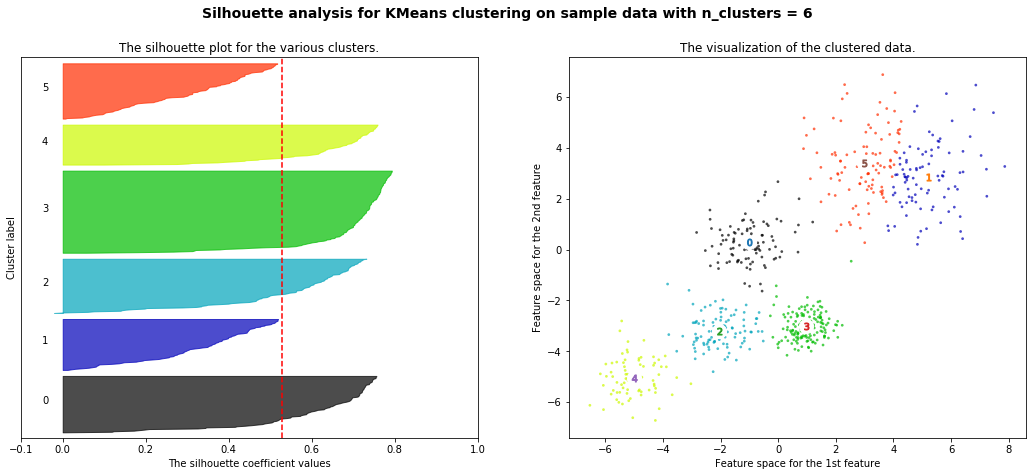

For n_clusters = 7 The average silhouette_score is : 0.533192524542


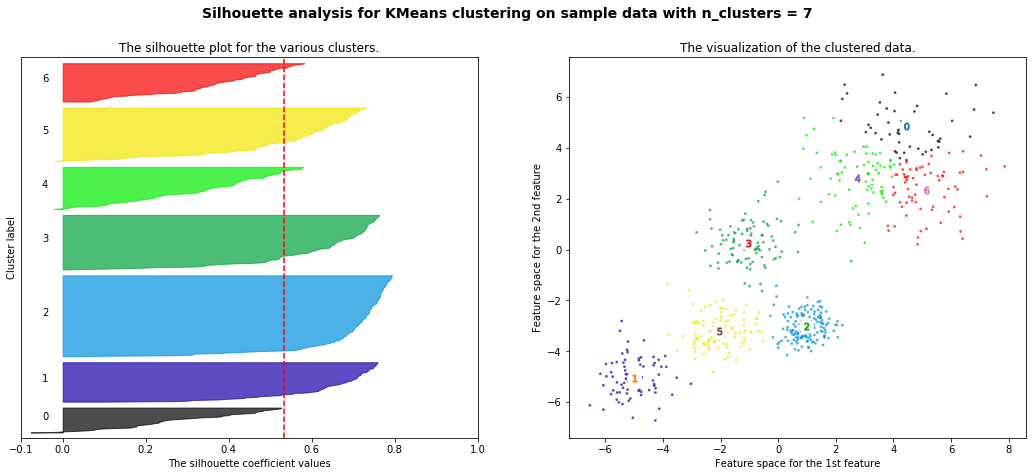

For n_clusters = 8 The average silhouette_score is : 0.52624927547


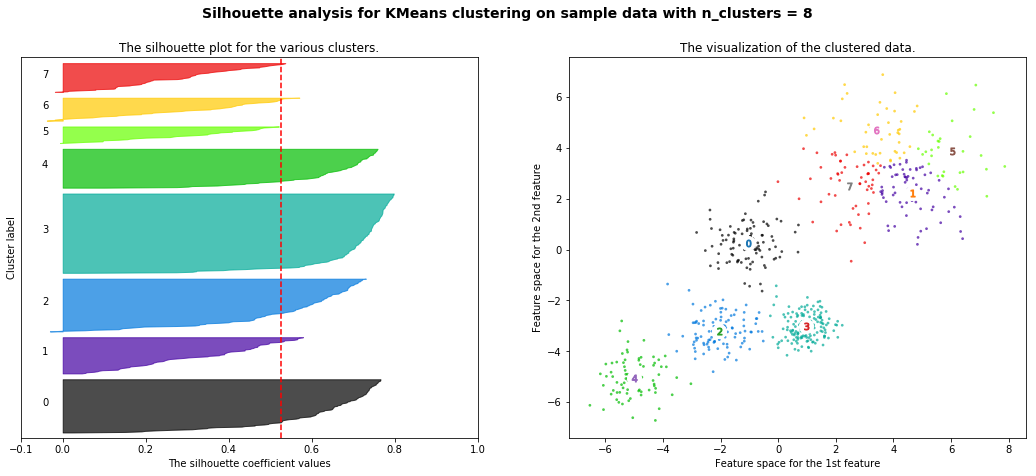

For n_clusters = 9 The average silhouette_score is : 0.527865539383


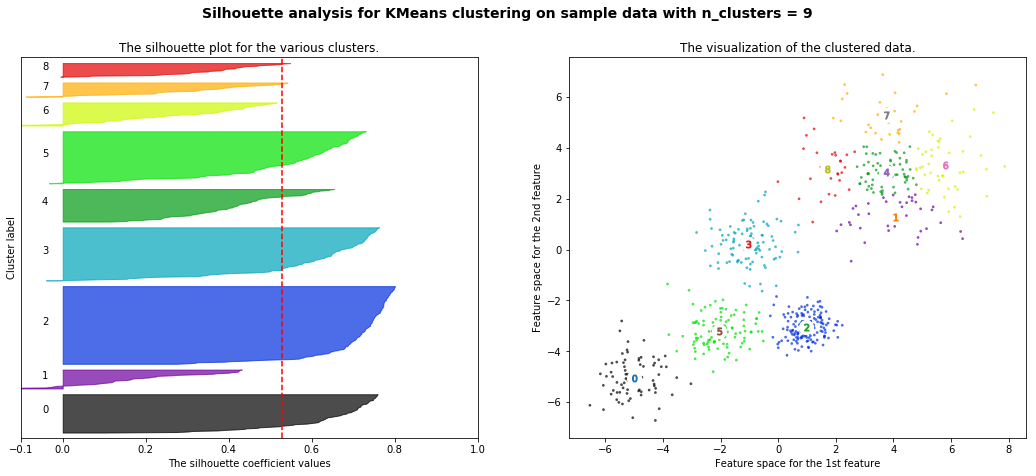

In [18]:
X = x
range_n_clusters = range(2,10)

# taken from sklearn
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

# Choosing K -- GAP Statistic

For each $K$, compare $W_K$ (within-cluster sum of squares) with that of randomly generated "reference distributions"

Generate B distributions

$$Gap(K) = \frac{1}{B} \sum_{b=1}^B \log{W_{Kb}} - \log{W_K}$$

Choose smallest K such that $Gap(K) \ge Gap(K+1) - s_{N+1}$

where $s_{K}$ is the standard error of $Gap(K)$

# Hierarchical Clustering

With many clustering methods the goal is to divide the data into a specific number of clusters. With hierarchical clustering we group data points as leaves on a tree, clustering them into larger and larger groups.

How would we group these?

![](images/letters-ungrouped.png)


<table><tr><td><img src='images/letters-grouped.png'></td><td><img src='images/letters-dendrogram.png'></td></tr></table>


# Hierarchical Clustering

The basic algorithm of hierarchical clustering is

 * Assign each point to its own cluster
 * Repeat:

   * Compute distances between clusters
   * Merge closest clusters

 ...until all are merged

How do we define dissimilarity between clusters?

## Linkage

It's easy to talk about the distance (or dissimilarity) between two points, but between clusters it's less clear. There are a few different measures used.

* **Complete:** Maximum pairwise dissimilarity between points in clusters -- good
* **Average:** Average of pairwise dissimilarity between points in clusters -- also good
* **Single:** Minimum pairwise dissimilarity between points in clusters -- not as good; can lead to long narrow clusters
* **Centroid:** Dissimilarity between centroids -- used in genomics; risk of inversions

# Problems with k-means and other methods

k-means has limitations.

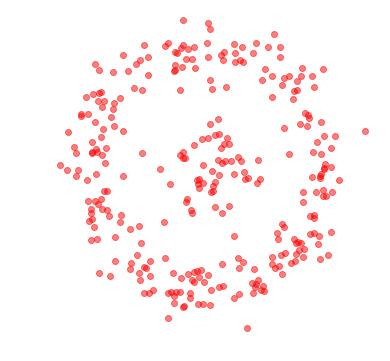

In [19]:
fig, ax = plt.subplots(figsize=(6,6))
r = np.concatenate([stats.norm(8,1).rvs(250),
                    stats.norm(2,1).rvs(50)])
a = stats.uniform(0, 6.28).rvs(300)
x = r * np.cos(a)
y = r * np.sin(a)

ax.axis('equal')
ax.axis('off')
ax.scatter(x, y, color="r", alpha=0.5)

What will k-means do here?

# DBSCAN

With DBSCAN (Density-Based Spacial Clustering of Applications with Noise) we don't specify the number of clusters. Instead we specify:

 * $\epsilon$: distance between points for them to be connected
 * minPts: number of connected points for a point to be a "core" point

A cluster is all connected core points, plus others within $\epsilon$ of one of those. Other points are noise.

Let's tackle the above problem with DBSCAN.

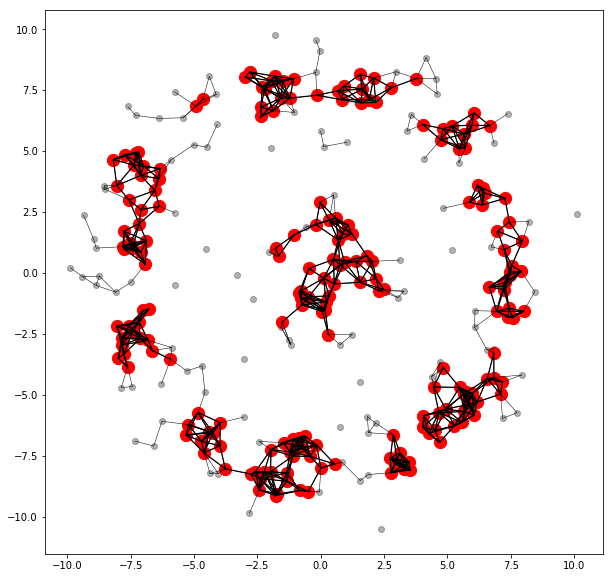

In [20]:
epsilon = 1.1
minpts = 4

fig, ax = plt.subplots(figsize=(10,10))

distances = squareform(pdist(np.stack([x,y], axis=1)))
connected = distances < epsilon
ax.scatter(x, y, color="k", alpha=0.3)
for i in range(len(x)):
    for j in range(i):
        if connected[i,j]:
            ax.plot([x[i], x[j]], [y[i], y[j]], 'k', lw=0.5)

coreindices = np.where(connected.sum(axis=0) > (minpts))[0]
ax.scatter(x[coreindices], y[coreindices], s=150, c='r')

for i in coreindices:
    for j in coreindices:
        if i > j and connected[i,j]:
            ax.plot([x[i], x[j]], [y[i], y[j]], 'k', lw=1.2)

# Distribution-based clustering

With distribution-based clustering we assume some fixed number of clusters, and assume they follow some (often normal) distribution. We then try to find the parameters that have the **maximum likelihood** of producing these data.

This is more difficult then other problems we've seen because we don't know which point came from which distribution. We need to add some hidden variables to the problem: the probability each point came from each distribution. We can solve this by an **expectation-maximization** (EM) algorithm in which we alternate between expectation steps (where we calculate the hidden variables) and maximization steps (in which we calculate the maximum-likelihood parameters assuming the hidden variables are correct).

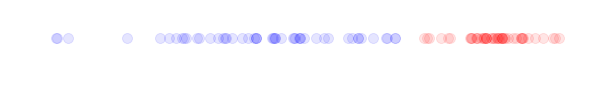

In [23]:
npts = 100
actual_mus = 1, 5
actual_sds = 1.5, 0.5
x = np.concatenate([stats.norm(actual_mus[0], actual_sds[0]).rvs(npts//2),
                    stats.norm(actual_mus[1] ,actual_sds[1]).rvs(npts//2)])
y = np.ones(npts)/2.
fig, ax = plt.subplots(figsize=(10,1))
ax.scatter(x[:npts//2], y[:npts//2], c='b', alpha=0.1, s=100)
ax.scatter(x[npts//2:], y[npts//2:], c='r', alpha=0.1, s=100)
ax.axis('off')
plt.show()

The first step is to make guesses for the two starting distrubitions. Let's go with N(0,1) and N(2,1).

In [24]:
mus = [-1, 0]
sds = [1, 1]
dists = [stats.norm(mu, sd) for mu, sd in zip(mus, sds)]
actual_dists = [stats.norm(mu, sd) for mu, sd in zip(actual_mus, actual_sds)]

      actual  estimate
mu_0  1.00    -1.000
mu_1  5.00    0.000
sd_0  1.50    1.000
sd_1  0.50    1.000


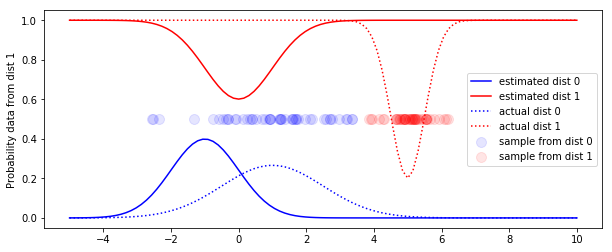

In [26]:
def plot_em(x, y, dists, actual_dists):
    xpts = np.linspace(-5,10,100)
    fig, ax = plt.subplots(figsize=(10,4))
    npts = len(x)
    ax.scatter(x[:npts//2], y[:npts//2], c='b', alpha=0.1, s=100, label="sample from dist 0")
    ax.scatter(x[npts//2:], y[npts//2:], c='r', alpha=0.1, s=100, label="sample from dist 1")
    ax.plot(xpts, dists[0].pdf(xpts), 'b', label="estimated dist 0")
    ax.plot(xpts, 1-dists[1].pdf(xpts), 'r',  label="estimated dist 1")
    ax.plot(xpts, actual_dists[0].pdf(xpts), 'b:',  label="actual dist 0")
    ax.plot(xpts, 1-actual_dists[1].pdf(xpts), 'r:',  label="actual dist 1")
    ax.set_ylabel("Probability data from dist 1")
    ax.legend()

def print_stats(actual_mus, actual_sds, mus, sds):
    #for i in (0, 1):
    print("      actual  estimate")
    print("mu_0  {0:.2f}    {1:.3f}".format(actual_mus[0], mus[0]))
    print("mu_1  {0:.2f}    {1:.3f}".format(actual_mus[1], mus[1]))
    print("sd_0  {0:.2f}    {1:.3f}".format(actual_sds[0], sds[0]))
    print("sd_1  {0:.2f}    {1:.3f}".format(actual_sds[1], sds[1]))

plot_em(x, y, dists, actual_dists)
print_stats(actual_mus, actual_sds, mus, sds)

Now we're going to calculate the relative likelihood that each point will be in `dist[1]` (the upper distribution, as opposed to `dist[0]`, the lower one).

We'll plot that.

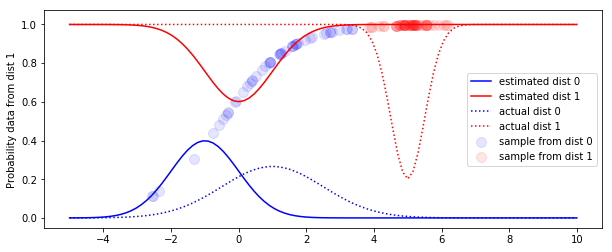

In [27]:
y = dists[1].pdf(x) / (dists[0].pdf(x) + dists[1].pdf(x))

plot_em(x, y, dists, actual_dists)

Now we update each distribution to be (normal) distribution that has the maximum likelihood of generating the data. We'll weight each point by the probability (calculated above) of being in that distribution.

We can just use the (weighted) means and standard deviations for this.

      actual  estimate
mu_0  1.00    -0.206
mu_1  5.00    3.496
sd_0  1.50    1.056
sd_1  0.50    1.786


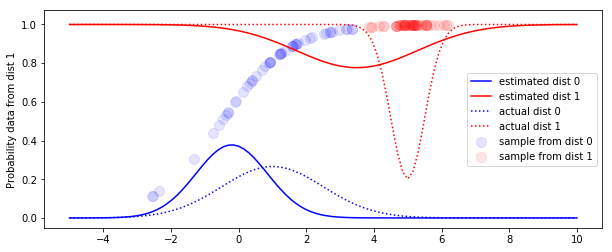

In [28]:
def weighted_stats(x, weights):
    wtotal = weights.sum()
    wmean = (x * weights).sum() / wtotal
    wsd = (((weights*(x - wmean))**2).sum() / wtotal)**0.5
    return wmean, wsd

mus[0], sds[0] = weighted_stats(x, 1-y)
mus[1], sds[1] = weighted_stats(x, y)
dists = [stats.norm(mu, sd) for mu, sd in zip(mus, sds)]

plot_em(x, y, dists, actual_dists)
print_stats(actual_mus, actual_sds, mus, sds)

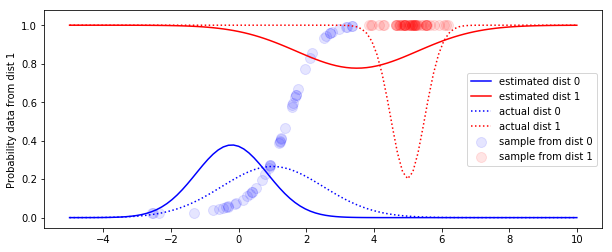

In [29]:
y = dists[1].pdf(x) / (dists[0].pdf(x) + dists[1].pdf(x))
plot_em(x, y, dists, actual_dists)

      actual  estimate
mu_0  1.00    0.174
mu_1  5.00    4.159
sd_0  1.50    1.058
sd_1  0.50    1.239


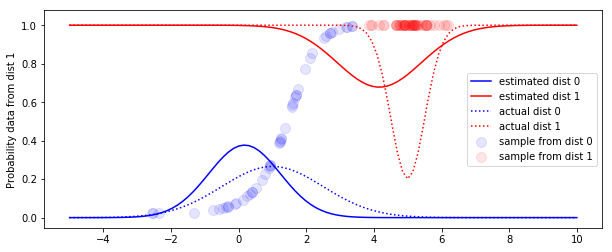

In [30]:
mus[0], sds[0] = weighted_stats(x, 1-y)
mus[1], sds[1] = weighted_stats(x, y)
dists = [stats.norm(mu, sd) for mu, sd in zip(mus, sds)]

plot_em(x, y, dists, actual_dists)
print_stats(actual_mus, actual_sds, mus, sds)

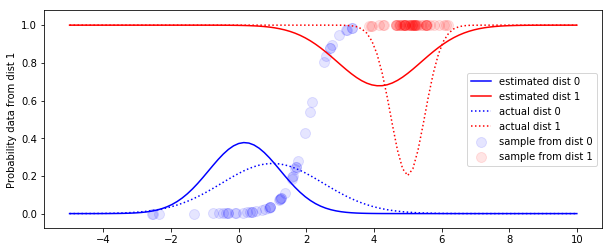

In [31]:
y = dists[1].pdf(x) / (dists[0].pdf(x) + dists[1].pdf(x))
plot_em(x, y, dists, actual_dists)

      actual  estimate
mu_0  1.00    0.442
mu_1  5.00    4.552
sd_0  1.50    1.132
sd_1  0.50    0.957


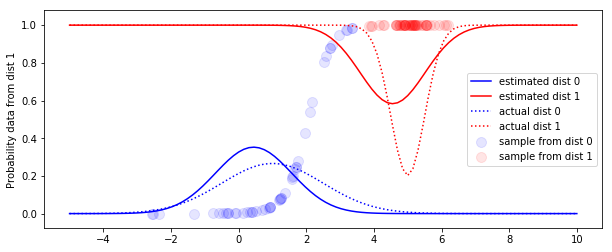

In [32]:
mus[0], sds[0] = weighted_stats(x, 1-y)
mus[1], sds[1] = weighted_stats(x, y)
dists = [stats.norm(mu, sd) for mu, sd in zip(mus, sds)]

plot_em(x, y, dists, actual_dists)
print_stats(actual_mus, actual_sds, mus, sds)

In [33]:
for i in range(100):
    y = dists[1].pdf(x) / (dists[0].pdf(x) + dists[1].pdf(x))
    mus[0], sds[0] = weighted_stats(x, 1-y)
    mus[1], sds[1] = weighted_stats(x, y)
    dists = [stats.norm(mu, sd) for mu, sd in zip(mus, sds)]

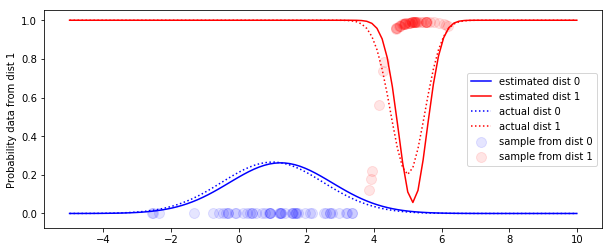

In [34]:
plot_em(x, y, dists, actual_dists)
